In [ ]:
import pandas as pd

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

# Cargar dataset (ajusta el path si es necesario)
df = pd.read_csv("/content/btcusd_1-min_data.csv")

# Preprocesamiento de fecha y cierre
df['Date'] = pd.to_datetime(df['Timestamp'], unit='s')
df = df.set_index('Date')[['Close']].copy()
df.dropna(inplace=True)

# Escalado
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(df[['Close']].values).flatten()

In [2]:
# Función para crear secuencias
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

# Modelo LSTM
class BitcoinLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(BitcoinLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

In [3]:
# Entrenamiento
def train_model(model, X_train, y_train, X_val, y_val, num_epochs, lr):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = model(X_val)
        val_loss = criterion(preds, y_val).item()
    return val_loss

In [ ]:
# import gc
# import random
# import torch
# from sklearn.model_selection import train_test_split

# def genetic_algorithm(y, pop_size=4, generations=2, max_samples=100_000):
#     population = []

#     # Crear población inicial
#     for _ in range(pop_size):
#         individual = {
#             'seq_len': random.randint(10, 50),
#             'hidden_size': random.choice([16, 32, 64, 128]),
#             'num_layers': random.choice([1, 2, 3]),
#             'dropout': random.uniform(0.0, 0.5),
#             'lr': random.uniform(0.0005, 0.01)
#         }
#         if individual['num_layers'] == 1:
#             individual['dropout'] = 0.0
#         population.append(individual)

#     for gen in range(generations):
#         fitness_scores = []

#         for ind in population:
#             seq_len = ind['seq_len']

#             # Limitar tamaño del dataset para no saturar la RAM
#             y_sample = y[:max_samples]

#             # Crear secuencias
#             X, y_seq = create_sequences(y_sample, seq_len)
#             if len(X) < 500:
#                 continue

#             X_train, X_val, y_train, y_val = train_test_split(X, y_seq, test_size=0.2, shuffle=False)

#             # Convertir a tensores
#             X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
#             y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
#             X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
#             y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

#             # Crear y entrenar modelo
#             model = BitcoinLSTM(1, ind['hidden_size'], ind['num_layers'], ind['dropout'])
#             loss = train_model(model, X_train, y_train, X_val, y_val, num_epochs=2, lr=ind['lr'])
#             fitness_scores.append((loss, ind))

#             # Liberar memoria
#             del model, X_train, y_train, X_val, y_val
#             torch.cuda.empty_cache()
#             gc.collect()

#         if len(fitness_scores) < 2:
#             print("⚠️ Muy pocos individuos válidos, intenta aumentar `pop_size` o mejorar `create_sequences`.")
#             break

#         # Seleccionar los mejores
#         fitness_scores.sort(key=lambda x: x[0])
#         best = fitness_scores[:max(2, pop_size // 2)]

#         new_population = [ind for _, ind in best]

#         # Cruce y mutación
#         while len(new_population) < pop_size:
#             if len(new_population) >= 2:
#                 p1, p2 = random.sample(new_population, 2)
#             else:
#                 p1 = p2 = new_population[0]

#             child = {
#                 'seq_len': random.choice([p1['seq_len'], p2['seq_len']]),
#                 'hidden_size': random.choice([p1['hidden_size'], p2['hidden_size']]),
#                 'num_layers': random.choice([p1['num_layers'], p2['num_layers']]),
#                 'dropout': max(0.0, min(0.5, (p1['dropout'] + p2['dropout']) / 2 + random.uniform(-0.05, 0.05))),
#                 'lr': max(0.0001, min(0.01, (p1['lr'] + p2['lr']) / 2 + random.uniform(-0.001, 0.001)))
#             }

#             if child['num_layers'] == 1:
#                 child['dropout'] = 0.0

#             new_population.append(child)

#         population = new_population
#         print(f"🧬 Gen {gen+1}/{generations}, Mejor pérdida: {best[0][0]:.6f}")

#     return fitness_scores[0][1]


In [ ]:
# import random
# import gc
# import torch
# import numpy as np
# from sklearn.model_selection import train_test_split

# def genetic_algorithm(y, pop_size=4, generations=2, max_samples=5000):
#     population = []
#     for _ in range(pop_size):
#         individual = {
#             'seq_len': random.randint(10, 30),
#             'hidden_size': random.choice([16, 32]),
#             'num_layers': random.choice([1, 2]),
#             'dropout': random.uniform(0.0, 0.3),
#             'lr': random.uniform(0.001, 0.005)
#         }
#         population.append(individual)

#     for gen in range(generations):
#         fitness_scores = []

#         for ind in population:
#             try:
#                 seq_len = ind['seq_len']
#                 X, y_seq = create_sequences(y, seq_len)

#                 # Limitar el tamaño total de muestras
#                 if len(X) > max_samples:
#                     indices = np.random.choice(len(X), size=max_samples, replace=False)
#                     X = X[indices]
#                     y_seq = y_seq[indices]

#                 if len(X) < 300:
#                     continue

#                 X_train, X_val, y_train, y_val = train_test_split(X, y_seq, test_size=0.2, shuffle=False)

#                 # Tensores
#                 X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
#                 y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
#                 X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
#                 y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

#                 # Crear modelo
#                 model = BitcoinLSTM(1, ind['hidden_size'], ind['num_layers'], ind['dropout'])
#                 loss = train_model(model, X_train, y_train, X_val, y_val, num_epochs=2, lr=ind['lr'])

#                 fitness_scores.append((loss, ind))

#                 # Liberar todo
#                 del model, X_train, y_train, X_val, y_val
#                 gc.collect()
#                 torch.cuda.empty_cache()

#             except Exception as e:
#                 print(f"❌ Error con individuo {ind}: {e}")
#                 continue

#         fitness_scores.sort(key=lambda x: x[0])
#         best = fitness_scores[:pop_size//2]
#         new_population = [ind for _, ind in best]

#         while len(new_population) < pop_size:
#             p1, p2 = random.sample(new_population, 2)
#             child = {
#                 'seq_len': random.choice([p1['seq_len'], p2['seq_len']]),
#                 'hidden_size': random.choice([p1['hidden_size'], p2['hidden_size']]),
#                 'num_layers': random.choice([p1['num_layers'], p2['num_layers']]),
#                 'dropout': max(0.0, min(0.5, (p1['dropout'] + p2['dropout']) / 2 + random.uniform(-0.05, 0.05))),
#                 'lr': max(0.0001, min(0.01, (p1['lr'] + p2['lr']) / 2 + random.uniform(-0.001, 0.001)))
#             }
#             new_population.append(child)

#         population = new_population
#         print(f"🧬 Gen {gen+1}/{generations}, mejor pérdida: {best[0][0]:.6f}")

#     return fitness_scores[0][1]


In [ ]:
# import gc
# import torch

# def genetic_algorithm(y, pop_size=10, generations=5):
#     population = []
#     for _ in range(pop_size):
#         individual = {
#             'seq_len': random.randint(10, 50),
#             'hidden_size': random.choice([16, 32, 64]),
#             'num_layers': random.choice([1, 2]),
#             'dropout': random.uniform(0.0, 0.3),
#             'lr': random.uniform(0.001, 0.005)
#         }
#         population.append(individual)

#     for gen in range(generations):
#         fitness_scores = []

#         for ind in population:
#             try:
#                 seq_len = ind['seq_len']
#                 X, y_seq = create_sequences(y, seq_len)
#                 if len(X) < 500:
#                     continue

#                 # Liberar memoria explícitamente antes de cada iteración
#                 gc.collect()
#                 torch.cuda.empty_cache()

#                 # Dividir datos
#                 X_train, X_val, y_train, y_val = train_test_split(X, y_seq, test_size=0.2, shuffle=False)

#                 # Crear tensores sin ocupar más memoria de la necesaria
#                 X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
#                 y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
#                 X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
#                 y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

#                 model = BitcoinLSTM(1, ind['hidden_size'], ind['num_layers'], ind['dropout'])
#                 loss = train_model(model, X_train, y_train, X_val, y_val, num_epochs=3, lr=ind['lr'])
#                 fitness_scores.append((loss, ind))

#                 # Borrar todo lo pesado
#                 del model, X_train, y_train, X_val, y_val
#                 gc.collect()
#                 torch.cuda.empty_cache()

#             except Exception as e:
#                 print(f"Error con individuo {ind}: {e}")
#                 continue

#         fitness_scores.sort(key=lambda x: x[0])
#         best = fitness_scores[:pop_size//2]
#         new_population = [ind for _, ind in best]

#         while len(new_population) < pop_size:
#             parent1, parent2 = random.sample(new_population, 2)
#             child = {
#                 'seq_len': random.choice([parent1['seq_len'], parent2['seq_len']]),
#                 'hidden_size': random.choice([parent1['hidden_size'], parent2['hidden_size']]),
#                 'num_layers': random.choice([parent1['num_layers'], parent2['num_layers']]),
#                 'dropout': max(0.0, min(0.5, (parent1['dropout'] + parent2['dropout']) / 2 + random.uniform(-0.05, 0.05))),
#                 'lr': max(0.0001, min(0.01, (parent1['lr'] + parent2['lr']) / 2 + random.uniform(-0.001, 0.001)))
#             }
#             new_population.append(child)

#         population = new_population
#         print(f"🧬 Generación {gen+1}/{generations}, Mejor pérdida: {best[0][0]:.6f}")

#     return fitness_scores[0][1]


In [ ]:
# import gc
# import torch
# import random
# from sklearn.model_selection import train_test_split

# def genetic_algorithm(y, pop_size=6, generations=3):
#     population = []

#     # Crear población inicial
#     for _ in range(pop_size):
#         individual = {
#             'seq_len': random.randint(10, 30),  # rango más pequeño
#             'hidden_size': random.choice([16, 32, 64]),
#             'num_layers': random.choice([1, 2]),
#             'dropout': round(random.uniform(0.0, 0.4), 2),
#             'lr': round(random.uniform(0.0005, 0.005), 5)
#         }
#         population.append(individual)

#     for gen in range(generations):
#         fitness_scores = []

#         for ind in population:
#             seq_len = ind['seq_len']
#             X, y_seq = create_sequences(y, seq_len)
#             if len(X) < 500:
#                 continue  # Evita conjuntos muy pequeños

#             X_train, X_val, y_train, y_val = train_test_split(X, y_seq, test_size=0.2, shuffle=False)

#             # Convertir a tensores (agregamos la dimensión del canal)
#             X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
#             y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
#             X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
#             y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

#             model = BitcoinLSTM(1, ind['hidden_size'], ind['num_layers'], ind['dropout'])

#             # Entrenar modelo
#             loss = train_model(model, X_train, y_train, X_val, y_val, num_epochs=3, lr=ind['lr'])

#             fitness_scores.append((loss, ind))

#             # 🔥 Liberar memoria usada por tensores y modelo
#             del model, X_train, y_train, X_val, y_val
#             gc.collect()
#             torch.cuda.empty_cache()  # si estás usando GPU

#         # Selección: los mejores sobrevivientes
#         fitness_scores.sort(key=lambda x: x[0])
#         best = fitness_scores[:pop_size // 2]
#         new_population = [ind for _, ind in best]

#         # Cruce y mutación
#         while len(new_population) < pop_size:
#             parent1, parent2 = random.sample(new_population, 2)
#             child = {
#                 'seq_len': random.choice([parent1['seq_len'], parent2['seq_len']]),
#                 'hidden_size': random.choice([parent1['hidden_size'], parent2['hidden_size']]),
#                 'num_layers': random.choice([parent1['num_layers'], parent2['num_layers']]),
#                 'dropout': max(0.0, min(0.5, (parent1['dropout'] + parent2['dropout']) / 2 + random.uniform(-0.05, 0.05))),
#                 'lr': max(0.0001, min(0.01, (parent1['lr'] + parent2['lr']) / 2 + random.uniform(-0.001, 0.001)))
#             }
#             new_population.append(child)

#         population = new_population
#         print(f"🧬 Generación {gen + 1}/{generations} - Mejor pérdida: {best[0][0]:.6f}")

#     return fitness_scores[0][1]  # Mejor individuo


In [ ]:
# best_hparams = genetic_algorithm(y=scaled_close, pop_size=4, generations=2)
# print("📌 Mejores hiperparámetros encontrados:", best_hparams)


🧬 Gen 1/2, Mejor pérdida: 0.000099
🧬 Gen 2/2, Mejor pérdida: 0.000041
📌 Mejores hiperparámetros encontrados: {'seq_len': 20, 'hidden_size': 32, 'num_layers': 3, 'dropout': 0.2653036041621139, 'lr': 0.0015289256279720606}


In [ ]:
# # Ejecutar algoritmo genético
# best_hparams = genetic_algorithm(y=scaled_close, pop_size=4, generations=2)
# print("🧬 Mejores hiperparámetros encontrados:", best_hparams)

In [4]:
# Entrenar modelo final
# seq_len = best_hparams['seq_len']
seq_len = 20
X, y_seq = create_sequences(scaled_close, seq_len)
X_train, X_val, y_train, y_val = train_test_split(X, y_seq, test_size=0.2, shuffle=False)

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

model = BitcoinLSTM(
    input_size=1,
    # hidden_size=best_hparams['hidden_size'],
    hidden_size=32,
    # num_layers=best_hparams['num_layers'],
    num_layers=3,
    # dropout=best_hparams['dropout']
    dropout=0.2653036041621139,
)

train_model(model, X_train, y_train, X_val, y_val, num_epochs=20,
            # lr=best_hparams['lr']
            lr=0.0015289256279720606)

0.02983376570045948

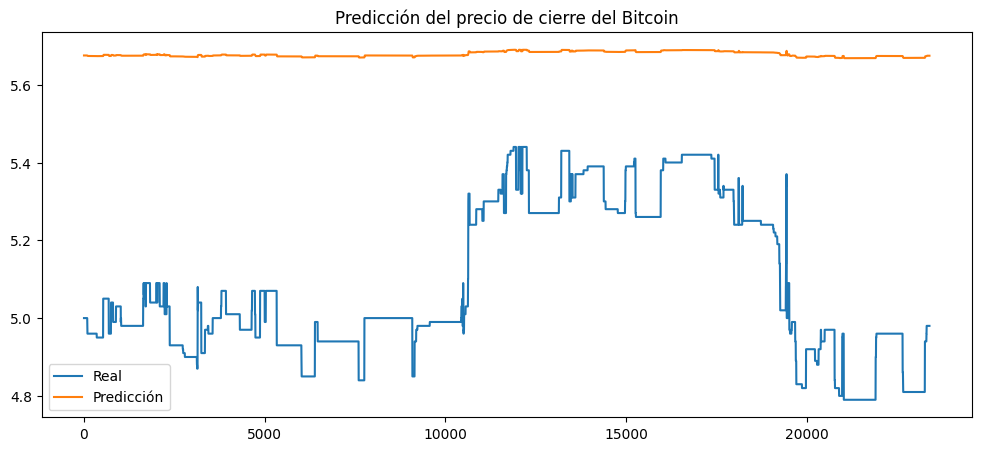

In [5]:

# Predicción y visualización
model.eval()
with torch.no_grad():
    preds = model(X_val).numpy()

actual = scaler.inverse_transform(y_val.numpy())
predicted = scaler.inverse_transform(preds)

plt.figure(figsize=(12, 5))
plt.plot(actual, label='Real')
plt.plot(predicted, label='Predicción')
plt.legend()
plt.title("Predicción del precio de cierre del Bitcoin")
plt.show()

In [ ]:
# import pandas as pd
# import numpy as np
# import torch
# import torch.nn as nn
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split
# import random
# import matplotlib.pyplot as plt

# # Cargar dataset (ajusta el path si es necesario)
# df = pd.read_csv("/content/btcusd_1-min_data.csv")

# # Preprocesamiento de fecha y cierre
# df['Date'] = pd.to_datetime(df['Timestamp'], unit='s')
# df = df.set_index('Date')[['Close']].copy()
# df.dropna(inplace=True)

# # Escalado
# scaler = MinMaxScaler()
# scaled_close = scaler.fit_transform(df[['Close']].values).flatten()

# # Función para crear secuencias
# def create_sequences(data, seq_len):
#     X, y = [], []
#     for i in range(len(data) - seq_len):
#         X.append(data[i:i+seq_len])
#         y.append(data[i+seq_len])
#     return np.array(X), np.array(y)

# # Modelo LSTM
# class BitcoinLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, dropout):
#         super(BitcoinLSTM, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
#                             dropout=dropout, batch_first=True)
#         self.fc = nn.Linear(hidden_size, 1)

#     def forward(self, x):
#         out, _ = self.lstm(x)
#         return self.fc(out[:, -1, :])

# # Entrenamiento
# def train_model(model, X_train, y_train, X_val, y_val, num_epochs, lr):
#     criterion = nn.MSELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#     for epoch in range(num_epochs):
#         model.train()
#         optimizer.zero_grad()
#         output = model(X_train)
#         loss = criterion(output, y_train)
#         loss.backward()
#         optimizer.step()

#     model.eval()
#     with torch.no_grad():
#         preds = model(X_val)
#         val_loss = criterion(preds, y_val).item()
#     return val_loss

# # Algoritmo genético
# def genetic_algorithm(y, pop_size=10, generations=5):
#     population = []
#     for _ in range(pop_size):
#         individual = {
#             'seq_len': random.randint(10, 50),
#             'hidden_size': random.choice([16, 32, 64, 128]),
#             'num_layers': random.choice([1, 2, 3]),
#             'dropout': random.uniform(0.0, 0.5),
#             'lr': random.uniform(0.0005, 0.01)
#         }
#         population.append(individual)

#     for gen in range(generations):
#         fitness_scores = []

#         for ind in population:
#             seq_len = ind['seq_len']
#             X, y_seq = create_sequences(y, seq_len)
#             if len(X) < 500: continue  # Evita conjuntos muy pequeños
#             X_train, X_val, y_train, y_val = train_test_split(X, y_seq, test_size=0.2, shuffle=False)

#             # Tensores
#             X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
#             y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
#             X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
#             y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

#             model = BitcoinLSTM(1, ind['hidden_size'], ind['num_layers'], ind['dropout'])
#             loss = train_model(model, X_train, y_train, X_val, y_val, num_epochs=5, lr=ind['lr'])
#             fitness_scores.append((loss, ind))

#         fitness_scores.sort(key=lambda x: x[0])
#         best = fitness_scores[:pop_size//2]
#         new_population = [ind for _, ind in best]

#         # Cruce y mutación
#         while len(new_population) < pop_size:
#             parent1, parent2 = random.sample(new_population, 2)
#             child = {
#                 'seq_len': random.choice([parent1['seq_len'], parent2['seq_len']]),
#                 'hidden_size': random.choice([parent1['hidden_size'], parent2['hidden_size']]),
#                 'num_layers': random.choice([parent1['num_layers'], parent2['num_layers']]),
#                 'dropout': max(0.0, min(0.5, (parent1['dropout'] + parent2['dropout']) / 2 + random.uniform(-0.05, 0.05))),
#                 'lr': max(0.0001, min(0.01, (parent1['lr'] + parent2['lr']) / 2 + random.uniform(-0.001, 0.001)))
#             }
#             new_population.append(child)

#         population = new_population
#         print(f"Gen {gen+1}/{generations}, Mejor pérdida: {best[0][0]:.6f}")

#     return fitness_scores[0][1]

# # Ejecutar algoritmo genético
# best_hparams = genetic_algorithm(y=scaled_close, pop_size=6, generations=3)
# print("🧬 Mejores hiperparámetros encontrados:", best_hparams)

# # Entrenar modelo final
# seq_len = best_hparams['seq_len']
# X, y_seq = create_sequences(scaled_close, seq_len)
# X_train, X_val, y_train, y_val = train_test_split(X, y_seq, test_size=0.2, shuffle=False)

# X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
# y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
# X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
# y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# model = BitcoinLSTM(
#     input_size=1,
#     hidden_size=best_hparams['hidden_size'],
#     num_layers=best_hparams['num_layers'],
#     dropout=best_hparams['dropout']
# )

# train_model(model, X_train, y_train, X_val, y_val, num_epochs=20, lr=best_hparams['lr'])

# # Predicción y visualización
# model.eval()
# with torch.no_grad():
#     preds = model(X_val).numpy()

# actual = scaler.inverse_transform(y_val.numpy())
# predicted = scaler.inverse_transform(preds)

# plt.figure(figsize=(12, 5))
# plt.plot(actual, label='Real')
# plt.plot(predicted, label='Predicción')
# plt.legend()
# plt.title("Predicción del precio de cierre del Bitcoin")
# plt.show()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10442988244752732 and num_layers=1
  warnings.warn(


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Convertir timestamp a datetime
df['Date'] = pd.to_datetime(df['Timestamp'], unit='s')

# Reordenar y usar solo 'Date' y 'Close'
df = df[['Date', 'Close']].copy()
df = df.sort_values('Date')

# Opcional: agrupar por hora o día si hay muchas repeticiones
df = df.resample('1H', on='Date').mean().dropna()

# Normalizar 'Close'
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df[['Close']])

# Crear secuencias para LSTM
def create_sequences(df, seq_len):
    X, y = [], []
    for i in range(len(df) - seq_len):
        X.append(df[i:i+seq_len])
        y.append(df[i+seq_len])
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(scaled_df, seq_length)

# Convertir a tensores
import torch
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()


<ipython-input-4-8ef987f2b017>:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('1H', on='Date').mean().dropna()


In [ ]:
import torch
import torch.nn as nn

class BitcoinLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(BitcoinLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Solo tomamos la salida del último paso de tiempo
        out = self.fc(out)
        return out

In [ ]:
def train_model(model, X_train, y_train, X_val, y_val, num_epochs=20, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        output = model(X_train)
        loss = criterion(output, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validación
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = criterion(val_output, y_val)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item():.6f} - Val Loss: {val_loss.item():.6f}")

    return model

In [ ]:
from sklearn.model_selection import train_test_split

# División simple
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Inicializar modelo
model = BitcoinLSTM()
trained_model = train_model(model, X_train, y_train, X_val, y_val)

Epoch [1/20] - Loss: 0.081905 - Val Loss: 0.029647
Epoch [2/20] - Loss: 0.074661 - Val Loss: 0.022332
Epoch [3/20] - Loss: 0.068413 - Val Loss: 0.015973
Epoch [4/20] - Loss: 0.063105 - Val Loss: 0.010588
Epoch [5/20] - Loss: 0.058746 - Val Loss: 0.006293
Epoch [6/20] - Loss: 0.055429 - Val Loss: 0.003284
Epoch [7/20] - Loss: 0.053368 - Val Loss: 0.001772
Epoch [8/20] - Loss: 0.052666 - Val Loss: 0.001729
Epoch [9/20] - Loss: 0.053051 - Val Loss: 0.002521
Epoch [10/20] - Loss: 0.053870 - Val Loss: 0.003171
Epoch [11/20] - Loss: 0.054101 - Val Loss: 0.003206
Epoch [12/20] - Loss: 0.053375 - Val Loss: 0.002753
Epoch [13/20] - Loss: 0.052015 - Val Loss: 0.002147
Epoch [14/20] - Loss: 0.050431 - Val Loss: 0.001666
Epoch [15/20] - Loss: 0.048873 - Val Loss: 0.001441
Epoch [16/20] - Loss: 0.047588 - Val Loss: 0.001468
Epoch [17/20] - Loss: 0.046527 - Val Loss: 0.001668
Epoch [18/20] - Loss: 0.045652 - Val Loss: 0.001931
Epoch [19/20] - Loss: 0.044755 - Val Loss: 0.002154
Epoch [20/20] - Loss:

In [ ]:
import random

def generate_individual():
    return {
        'hidden_size': random.choice([16, 32, 64, 128]),
        'num_layers': random.choice([1, 2, 3]),
        'dropout': random.choice([0.0, 0.2, 0.5]),
        'lr': 10 ** random.uniform(-4, -2),  # Log scale: 0.0001 - 0.01
        'seq_len': random.choice([10, 20, 30, 50])
    }

In [ ]:
def fitness(individual, X, y):
    from sklearn.model_selection import train_test_split
    import torch

    # Repreparar datos según `seq_len`
    seq_len = individual['seq_len']
    X_seq, y_seq = create_sequences(y, seq_len)  # <-- asume que usas create_sequences

    X_train, X_val, y_train, y_val = train_test_split(
        X_seq, y_seq, test_size=0.2, shuffle=False)

    # Convertir a tensores
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    # Modelo
    model = BitcoinLSTM(
        input_size=1,
        hidden_size=individual['hidden_size'],
        num_layers=individual['num_layers'],
        dropout=individual['dropout']
    )

    trained = train_model(
        model, X_train, y_train, X_val, y_val,
        num_epochs=5,  # entrenamiento corto por eficiencia
        lr=individual['lr']
    )

    # Evaluar fitness
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        mse = nn.MSELoss()(val_output, y_val)

    return mse.item()

In [ ]:
def genetic_algorithm(X, y, pop_size=10, generations=5):
    population = [generate_individual() for _ in range(pop_size)]

    for generation in range(generations):
        print(f"Generación {generation+1}/{generations}")
        fitness_scores = [fitness(ind, X, y) for ind in population]

        # Seleccionar los mejores
        sorted_population = [x for _, x in sorted(zip(fitness_scores, population))]
        population = sorted_population[:pop_size//2]  # top 50%

        # Reproducir
        children = []
        while len(children) < pop_size // 2:
            parent1 = random.choice(population)
            parent2 = random.choice(population)

            # Cruce simple
            child = {
                key: random.choice([parent1[key], parent2[key]])
                for key in parent1
            }

            # Mutación
            if random.random() < 0.3:
                child = mutate(child)

            children.append(child)

        population += children

    # Última evaluación
    final_scores = [fitness(ind, X, y) for ind in population]
    best_idx = final_scores.index(min(final_scores))
    best_individual = population[best_idx]

    print(f"Mejores hiperparámetros encontrados: {best_individual}")
    return best_individual

In [ ]:
def mutate(individual):
    mutated = individual.copy()
    key = random.choice(list(mutated.keys()))
    if key == 'hidden_size':
        mutated[key] = random.choice([16, 32, 64, 128])
    elif key == 'num_layers':
        mutated[key] = random.choice([1, 2, 3])
    elif key == 'dropout':
        mutated[key] = random.choice([0.0, 0.2, 0.5])
    elif key == 'lr':
        mutated[key] = 10 ** random.uniform(-4, -2)
    elif key == 'seq_len':
        mutated[key] = random.choice([10, 20, 30, 50])
    return mutated